# Luz de Luna

Luz de Luna es una pequeña empresa con sede en Bogotá, especializada en la elaboración y distribución de cosméticos naturales hechos a base de ingredientes orgánicos, como aceites esenciales, manteca de karité y extractos botánicos.

Para expandir su presencia en el mercado nacional, la empresa realiza envíos de muestras de productos (como cremas, aceites y exfoliantes) a sus clientes mayoristas ubicados en distintos lugares de Bogotá.

La empresa cuenta con una furgoneta que parte del almacén central en Bogotá. Esta furgoneta debe:

1. Visitar a n clientes, cada uno en una ciudad diferente del país.
2. Hacer una única visita por cliente para entregar las muestras.
3. Regresar al almacén una vez finalizado el recorrido.

El objetivo es minimizar la distancia recorrida.

---

El **Problema del Viajante** (*Traveling Salesperson Problem*, TSP) consiste en encontrar un recorrido de costo mínimo que visite **exactamente una vez** cada ciudad (o punto) de un conjunto dado y **regrese al punto de partida**. El “costo” puede representar distancia, tiempo, dinero u otra medida asociada a viajar entre pares de ciudades.


## Datos

In [50]:
import time
import sys
import os

# ============================================================================
# Preparación del entorno y carga de datos para problema TSP
# ============================================================================
# Este script configura el entorno de trabajo e importa funciones desde un
# módulo externo para generar datos sintéticos del problema del viajante (TSP).
# Se generan ubicaciones geográficas de clientes, se calcula una matriz de
# distancias y se define una estructura para almacenar resultados de algoritmos.
# ============================================================================

# --------------------------------------------------------------------------
# 1. AJUSTAR EL PATH PARA ACCEDER A MÓDULOS PERSONALIZADOS
# --------------------------------------------------------------------------
# Se agrega el directorio '../Instances' al path para importar funciones propias
sys.path.append(os.path.abspath("../Instances"))

# --------------------------------------------------------------------------
# 2. IMPORTAR FUNCIONES DE GENERACIÓN Y UTILIDADES PARA TSP
# --------------------------------------------------------------------------
from InsTSP import (
    generar_datos,       # Genera coordenadas geográficas de nodos (clientes)
    distancias_tsp,      # Calcula matriz de distancias entre nodos
    reconstruir_tour,    # Reconstruye la ruta óptima desde solución de TSP
    graficar_ruta        # Visualiza el recorrido en coordenadas geográficas
)

# --------------------------------------------------------------------------
# 3. GENERAR DATOS DE PRUEBA PARA EL PROBLEMA DEL VIAJANTE
# --------------------------------------------------------------------------
# ▸ Se generan (EJEMPLO) 150 ubicaciones (149 clientes + 1 bodega)
clientes = generar_datos(250)

# ▸ Se construye la matriz de distancias usando coordenadas longitudinales
distancias = distancias_tsp(clientes, modo='long')

# --------------------------------------------------------------------------
# 4. PREPARAR ESTRUCTURA PARA ALMACENAR RESULTADOS DE ALGORITMOS
# --------------------------------------------------------------------------
resultados = []  # Lista donde se almacenarán métricas de desempeño y soluciones

# --------------------------------------------------------------------------
# 5. MOSTRAR DATOS GENERADOS (para inspección preliminar)
# --------------------------------------------------------------------------
print("Nodos generados (clientes + bodega):")
print(clientes)
print()

print("Matriz de distancias entre nodos:")
print(distancias)
print()


Nodos generados (clientes + bodega):
         ID     Tipo   Latitud   Longitud
0    Bodega   Bodega  4.792330 -74.192856
1       C01  Cliente  4.583752 -74.168466
2       C02  Cliente  4.624061 -74.110291
3       C03  Cliente  4.727344 -74.148335
4       C04  Cliente  4.610894 -74.114876
..      ...      ...       ...        ...
246    C246  Cliente  4.758788 -74.016828
247    C247  Cliente  4.801733 -74.191301
248    C248  Cliente  4.574558 -74.152276
249    C249  Cliente  4.759942 -74.099565
250    C250  Cliente  4.817722 -74.078291

[251 rows x 4 columns]

Matriz de distancias entre nodos:
       Origen Destino    Dist_km
0      Bodega     C01  23.349791
1      Bodega     C02  20.828060
2      Bodega     C03   8.749600
3      Bodega     C04  21.947705
4      Bodega     C05   8.701674
...       ...     ...        ...
31370    C247    C249  11.176901
31371    C247    C250  12.647474
31372    C248    C249  21.425528
31373    C248    C250  28.254413
31374    C249    C250   6.843645

[31

## Func. Aux.

In [51]:
import math

# ============================================================================
# Conteo y estimación de complejidad por fuerza bruta (TSP o similares)
# ============================================================================
# Este módulo permite:
#   • Calcular cuántos subconjuntos de tamaño ≥2 existen en un conjunto dado
#   • Estimar cuánto tiempo tomaría explorar todos esos subconjuntos
#     bajo un tiempo promedio por evaluación (en segundos)
# ============================================================================


def contar_subconjuntos(N: list) -> int:
    """
    ============================================================================
    Cuenta todos los subconjuntos posibles de tamaño ≥ 2 que se pueden formar
    ─────────────────────────────────────────────────────────────────────────────
    Entrada:
      • N : list
          Conjunto base de elementos (por ejemplo, nodos de un grafo)

    Salida:
      • int : número total de subconjuntos posibles de tamaño ≥ 2

    Fórmula:
      ∑_{r=2}^{n-1} C(n, r)
      (no incluye subconjuntos de tamaño 0, 1 ni n)
    ============================================================================
    """
    return sum(math.comb(len(N), r) for r in range(2, len(N)))


def estimar_tiempo_exploracion(total_subconjuntos: int,
                                tiempo_por_subconjunto: float = 1e-6) -> float:
    """
    ============================================================================
    Estima el tiempo total (en años) necesario para explorar todos los subconjuntos
    ─────────────────────────────────────────────────────────────────────────────
    Entrada:
      • total_subconjuntos     : int
            Número total de subconjuntos a evaluar
      • tiempo_por_subconjunto : float
            Tiempo estimado en segundos que toma procesar cada subconjunto

    Salida:
      • float : tiempo total estimado en años

    Notas:
      • Se utiliza un calendario gregoriano promedio de 365.25 días por año
      • Por defecto, cada evaluación toma 1 microsegundo (1e-6 s)
    ============================================================================
    """
    tiempo_total_s = total_subconjuntos * tiempo_por_subconjunto
    tiempo_total_años = tiempo_total_s / (60 * 60 * 24 * 365.25)
    return tiempo_total_años


## Optimización (MIP)

### Formulación

Suponemos un conjunto de ubicaciones formado por una **bodega (nodo 0)** y **n clientes** numerados $1,\dots,n$. Para cada par ordenado de nodos distintos $(i,j)$ se conoce un costo $c_{ij} \ge 0$ (p. ej., distancia). El objetivo es encontrar un tour cerrado de costo mínimo que salga de la bodega, visite **exactamente una vez** cada cliente y regrese al origen.


##### 1. Conjuntos
- $N = \{0,1,2,\dots,n\}$: nodos (0 = bodega).
- $A = \{(i,j) : i,j \in N,\ i \ne j\}$: arcos dirigidos en el grafo completo. (Si el problema es simétrico, los datos pueden cumplir $c_{ij} = c_{ji}$; aun así es común trabajar con la red dirigida.)


##### 2. Parámetros
- $c_{ij}$: costo de viajar de $i$ a $j$, para todo $(i,j) \in A$ (distancia, tiempo, etc.).


##### 3. Variables de decisión
$$
x_{ij} =
\begin{cases}
1 & \text{si el tour usa el arco }(i,j),\\
0 & \text{en otro caso,}
\end{cases}
\qquad (i,j) \in N.
$$


##### 4. Función objetivo
$$
\min \sum_{(i,j) \in N} c_{ij}\, x_{ij}.
$$


##### 5. Restricciones

###### 5.1 Salida única de cada nodo
$$
\sum_{j \in N,\ j \ne i} x_{ij} = 1 \qquad \forall i \in N.
$$

###### 5.2 Entrada única a cada nodo
$$
\sum_{j \in N,\ j \ne i} x_{ji} = 1 \qquad \forall i \in N.
$$

> Las dos familias anteriores aseguran grado 1 de salida y entrada en cada nodo, pero todavía permiten la aparición de subtours disjuntos; se requieren las restricciones DFJ para forzar un único tour que cubra a todos los nodos.


###### 5.3 Restricciones DFJ de eliminación de subtours

**Forma “subtour edge bound” (clásica):**
$$
\sum_{i \in S} \sum_{j \in S,\ j \ne i} x_{ij} \le |S| - 1
\qquad \forall S \subset N,\ 2 \le |S| \le n.
$$

Esta desigualdad impide que los nodos de cualquier subconjunto propio $S$ formen por sí solos un ciclo completo (lo que requeriría $|S|$ arcos internos).

###### 5.4 Naturaleza de las variables
$$
x_{ij} \in \{0,1\} \qquad \forall (i,j) \in A.
$$


### Parámetros

In [52]:
# ============================================================================
# Preparación de estructuras para resolución del TSP (modelo general)
# ============================================================================
# A partir del DataFrame de nodos y de distancias, se construyen:
#   • N : conjunto de nodos (identificadores únicos)
#   • A : diccionario de distancias entre pares de nodos (arcos dirigidos)
#         con simetría explícita (i,j) ↔ (j,i)
# ============================================================================

# --------------------------------------------------------------------------
# 1. Conjunto de nodos (IDs únicos)
# --------------------------------------------------------------------------
N = list(clientes['ID'])  # incluye bodega y clientes

# --------------------------------------------------------------------------
# 2. Diccionario de distancias entre nodos (formato: A[(i, j)] = distancia_km)
# --------------------------------------------------------------------------
# ▸ Extrae pares (i, j) y su distancia desde el DataFrame de arcos
# ▸ Asegura que si (i, j) existe, también esté (j, i), salvo diagonales

A = {
    (i, j): float(d)
    for i, j, d in distancias[['Origen', 'Destino', 'Dist_km']].itertuples(index=False)
}

# ▸ Agrega la dirección inversa (j, i) si no está definida y i ≠ j
A.update({
    (j, i): d
    for (i, j), d in A.items()
    if (j, i) not in A and i != j
})


### Modelo (Clásico)

In [53]:
import itertools
import pulp as lp

# ============================================================================
# Modelo exacto de TSP clásico (problema del viajante) con PuLP
# ============================================================================
# Minimiza el costo total de un ciclo hamiltoniano que visita todos los nodos
# exactamente una vez. Usa variables binarias x[i,j] y elimina subtours mediante
# restricciones de tipo MTZ generalizadas (combinaciones explícitas).
# ============================================================================
def optimizar_tcl_clasico(N: list, A: dict) -> tuple[lp.LpProblem, dict]:
    """
    ============================================================================
    Resolver TSP clásico (problema del ciclo hamiltoniano mínimo) vía MILP
    ─────────────────────────────────────────────────────────────────────────────
    Formula un modelo de programación entera binaria para resolver el TSP exacto.

    Parámetros:
      • N : list
          Lista de nodos (identificadores únicos, e.g., ['Bodega', 'C01', ..., 'C10'])

      • A : dict
          Diccionario de distancias entre pares de nodos: A[(i,j)] = distancia

    Salida:
      • model : objeto PuLP con la formulación del modelo (útil para análisis)
      • x     : diccionario de variables binarias: x[i,j] = 1 si se viaja de i a j
    ============================================================================
    """

    # ------------------------------------------------------------------------
    # 1. DEFINICIÓN DEL MODELO
    # ------------------------------------------------------------------------
    model = lp.LpProblem("TSP", lp.LpMinimize)

    # ------------------------------------------------------------------------
    # 2. VARIABLES DE DECISIÓN
    # ------------------------------------------------------------------------
    # x[i,j] = 1 si se elige el arco desde i hacia j (i ≠ j)
    x = {
        (i, j): lp.LpVariable(f"x_{i}_{j}", cat=lp.LpBinary)
        for i in N for j in N if i != j
    }

    # ------------------------------------------------------------------------
    # 3. FUNCIÓN OBJETIVO: minimizar la distancia total recorrida
    # ------------------------------------------------------------------------
    model += lp.lpSum(x[i, j] * A[i, j] for i, j in x), "Costo_total"

    # ------------------------------------------------------------------------
    # 4. RESTRICCIONES DE GRAFO: flujo de entrada y salida por nodo
    # ------------------------------------------------------------------------

    # ▸ Cada nodo tiene una única salida
    for i in N:
        model += lp.lpSum(x[i, j] for j in N if i != j) == 1, f"Salida_{i}"

    # ▸ Cada nodo tiene una única entrada
    for i in N:
        model += lp.lpSum(x[j, i] for j in N if i != j) == 1, f"Entrada_{i}"

    # ------------------------------------------------------------------------
    # 5. RESTRICCIONES DE SUBTOURS (combinaciones de subconjuntos)
    # ------------------------------------------------------------------------
    # ▸ Se eliminan ciclos menores a |N| con:
    #       ∑_{i,j ∈ S, i≠j} x[i,j] ≤ |S| - 1
    # ▸ Esto crece exponencialmente → solo viable para tamaños pequeños
    S_list = [
        tuple(S)
        for r in range(2, len(N))
        for S in itertools.combinations(N, r)
    ]
    for idx, S in enumerate(S_list):
        model += lp.lpSum(x[i, j] for i in S for j in S if i != j) <= len(S) - 1, f"Subtour_{idx}"

    # ------------------------------------------------------------------------
    # 6. RESOLVER MODELO
    # ------------------------------------------------------------------------
    solver = lp.PULP_CBC_CMD(msg=False)
    model.solve(solver)

    # ------------------------------------------------------------------------
    # 7. REPORTE DE ESTADO
    # ------------------------------------------------------------------------
    print("Estado de solución:", lp.LpStatus[model.status])

    return model, x


### Modelo (Lazy)

In [54]:
# ============================================================================
# Modelo TSP sin eliminación anticipada de subtours ("Lazy Start")
# ============================================================================
# Formula un modelo de TSP clásico (basado en flujo binario), pero **sin**
# incluir restricciones de subtour desde el inicio.
#
# Se resuelve el problema con solo las restricciones de grado (entrada/salida),
# lo cual permite analizar soluciones iniciales o usarlo como base para
# callbacks o lazy constraints (en solvers más avanzados).
# ============================================================================
def optimizar_tcl_lazy_start(N: list, A: dict) -> tuple[lp.LpProblem, dict]:
    """
    ============================================================================
    Optimización del TSP con restricciones mínimas (modelo relajado)
    ─────────────────────────────────────────────────────────────────────────────
    Este modelo busca un ciclo mínimo sin incluir restricciones de subtour.
    Útil como punto de partida para técnicas iterativas o detección de subtours.

    Parámetros:
      • N : list
          Lista de nodos (IDs únicos, incluyendo la bodega)
      • A : dict
          Diccionario con distancias: A[(i, j)] = distancia_km

    Salida:
      • model : objeto PuLP con el modelo formulado
      • x     : diccionario de variables binarias de decisión: x[i, j] ∈ {0, 1}
    ============================================================================
    """

    # ------------------------------------------------------------------------
    # 1. DEFINICIÓN DEL MODELO
    # ------------------------------------------------------------------------
    model = lp.LpProblem("TSP_Lazy", lp.LpMinimize)

    # ------------------------------------------------------------------------
    # 2. VARIABLES DE DECISIÓN
    # ------------------------------------------------------------------------
    # x[i,j] = 1 si se viaja del nodo i al nodo j (para i ≠ j)
    x = {
        (i, j): lp.LpVariable(f"x_{i}_{j}", cat=lp.LpBinary)
        for i in N for j in N if i != j
    }

    # ------------------------------------------------------------------------
    # 3. FUNCIÓN OBJETIVO: minimizar la distancia total recorrida
    # ------------------------------------------------------------------------
    model += lp.lpSum(x[i, j] * A[i, j] for i, j in x), "Costo_total"

    # ------------------------------------------------------------------------
    # 4. RESTRICCIONES DE GRADO (flujo)
    # ------------------------------------------------------------------------

    # ▸ Una única salida por nodo
    for i in N:
        model += lp.lpSum(x[i, j] for j in N if i != j) == 1, f"Salida_{i}"

    # ▸ Una única entrada por nodo
    for i in N:
        model += lp.lpSum(x[j, i] for j in N if i != j) == 1, f"Entrada_{i}"

    # ------------------------------------------------------------------------
    # 5. RESOLVER MODELO
    # ------------------------------------------------------------------------
    solver = lp.PULP_CBC_CMD(msg=False)
    model.solve(solver)

    # (No se imprime el estado aquí para mantenerlo modular)

    return model, x


In [55]:
# ============================================================================
# Identificación de subtours en soluciones parciales de TSP
# ============================================================================
# A partir del diccionario de sucesores (succ), se recorren los nodos para
# identificar ciclos cerrados (subtours) que violan el requisito del ciclo único.
# ============================================================================

def identificar_subtours(succ: dict, N: list) -> list[list[str]]:
    """
    ============================================================================
    Identifica subtours en una solución de TSP basada en sucesores directos.
    ─────────────────────────────────────────────────────────────────────────────
    Entrada:
      • succ : dict
          Diccionario con asignaciones de sucesor → succ[i] = j, si se va de i a j
      • N    : list
          Lista de todos los nodos en la instancia

    Salida:
      • subtours : list[list[str]]
          Lista de ciclos encontrados. Cada subtour es una lista de nodos en orden.

    Notas:
      • Esta función no asume que hay un solo tour: retorna todos los ciclos cerrados.
      • No incluye tours incompletos (sin sucesor), pero sí ciclos de tamaño ≥ 1.
    ============================================================================
    """
    unvisited = set(N)   # Nodos que aún no han sido asignados a ningún tour
    subtours = []        # Lista de subtours identificados

    # Recorremos todos los nodos hasta agruparlos en ciclos
    while unvisited:
        
        start = unvisited.pop()  # Nodo inicial del subtour
        tour = [start]
        cur = start

        while True:
            nxt = succ.get(cur)

            # Finaliza el subtour si no hay sucesor o se cierra el ciclo
            if nxt is None or nxt == start:
                break

            tour.append(nxt)
            if nxt in unvisited:
                unvisited.remove(nxt)
            cur = nxt

        subtours.append(tour)

    return subtours


In [56]:
import pulp as lp

# ============================================================================
# Actualización iterativa del modelo TSP con eliminación de subtours
# ============================================================================
# Esta función toma un modelo de TSP parcialmente resuelto (sin restricciones
# de subtour), identifica los ciclos indeseados y los elimina agregando nuevas
# restricciones al modelo antes de resolverlo nuevamente.
# ============================================================================

def optimizar_tcl_lazy_update(model: lp.LpProblem,
                              x: dict,
                              subtours: list[list[str]]) -> tuple[lp.LpProblem, dict]:
    """
    ============================================================================
    Añade restricciones de subtour al modelo y resuelve nuevamente
    ─────────────────────────────────────────────────────────────────────────────
    Entrada:
      • model    : objeto PuLP del modelo actual (sin subtour o con pocos cortes)
      • x        : diccionario de variables binarias x[i,j] ∈ {0,1}
      • subtours : lista de subtours (cada uno como lista de nodos)

    Comportamiento:
      • Por cada subtour S, agrega la restricción:
            ∑_{i,j ∈ S, i≠j} x[i,j] ≤ |S| - 1
        lo cual fuerza a romper el ciclo.

    Salida:
      • model : modelo resuelto después de agregar las nuevas restricciones
      • x     : diccionario de variables (referencia sin cambios)
    ============================================================================
    """
    # ------------------------------------------------------------------------
    # 1. AGREGAR CORTES DE SUBTOUR AL MODELO
    # ------------------------------------------------------------------------
    for S in subtours:
        if len(S) <= 1:
            continue  # No se agrega restricción si el "subtour" es trivial
        model += lp.lpSum(
            x[(i, j)] for i in S for j in S if i != j and (i, j) in x
        ) <= len(S) - 1, f"Subtour_elim_{'_'.join(S)}"

    # ------------------------------------------------------------------------
    # 2. RESOLVER MODELO CON NUEVAS RESTRICCIONES
    # ------------------------------------------------------------------------
    solver = lp.PULP_CBC_CMD(msg=False)
    model.solve(solver)

    return model, x


In [57]:
# ============================================================================
# Resolución iterativa del TSP con eliminación progresiva de subtours
# ============================================================================
# Esta función implementa una estrategia tipo "cutting plane", en la que:
#   1. Se resuelve un modelo inicial sin restricciones de subtour
#   2. Se identifican ciclos inválidos (subtours)
#   3. Se agregan restricciones para eliminarlos
#   4. Se reoptimiza el modelo
# El proceso se repite hasta obtener un único tour válido o agotar iteraciones.
# ============================================================================

def optimizar_tcl_lazy(N: list, A: dict) -> tuple[lp.LpProblem, dict]:
    """
    ============================================================================
    Modelo exacto de TSP con eliminación iterativa de subtours (Lazy Constraints)
    ─────────────────────────────────────────────────────────────────────────────
    Ejecuta un proceso iterativo de resolución del problema TSP donde se agregan
    restricciones de subtour solo cuando se detectan en la solución actual.

    Parámetros:
      • N : list
          Lista de nodos (identificadores únicos)
      • A : dict
          Diccionario con distancias: A[(i,j)] = distancia entre nodos

    Salida:
      • model : objeto PuLP final (puede incluir cortes de subtour)
      • x     : diccionario de variables binarias: x[i,j] = 1 si se toma ese arco
    ============================================================================
    """
    # ------------------------------------------------------------------------
    # 1. Resolver modelo base (sin cortes de subtour)
    # ------------------------------------------------------------------------
    model, x = optimizar_tcl_lazy_start(N, A)

    if lp.LpStatus[model.status] != "Optimal":
        print("No se encontró una solución inicial óptima.")
        return model, x

    # ------------------------------------------------------------------------
    # 2. Proceso iterativo de eliminación de subtours
    # ------------------------------------------------------------------------
    for iteracion in range(1000):
        # ▸ Extraer arcos activos de la solución
        succ = {i: j for (i, j) in x if lp.value(x[(i, j)]) == 1}

        # ▸ Detectar subtours presentes en la solución actual
        subtours = identificar_subtours(succ, N)

        # ▸ Si hay un solo ciclo que cubre todos los nodos, se ha terminado
        if len(subtours) == 1 and len(subtours[0]) == len(N):
            print(f"Tour válido encontrado en iteración {iteracion}.\n")
            break

        # ▸ Agregar cortes y resolver nuevamente
        t_init_temp = time.perf_counter()
        model, x = optimizar_tcl_lazy_update(model, x, subtours)
        elapsed_temp = time.perf_counter() - t_init_temp

        print(f"Se invalidaron {len(subtours)} subtours --> Time solver: {round(elapsed_temp, 3)} seg.")

        # ▸ Verificar si el modelo sigue siendo factible
        if lp.LpStatus[model.status] != "Optimal":
            print("Modelo se volvió infactible tras agregar cortes.")
            break
    else:
        print("Límite de iteraciones alcanzado sin tour único (no convergió).")

    return model, x


### Main


 -------------------------------- 
 -----    OPTIMIZADOR     ------- 
 -------------------------------- 

El espacio de búsqueda es mayor a: 3.619e+75 subconjuntos.
Tiempo estimado por fuerza bruta: 1.147e+62 años.

Instancia grande detectada: se usará enfoque iterativo (lazy).

Se invalidaron 114 subtours --> Time solver: 4.536 seg.
Se invalidaron 61 subtours --> Time solver: 4.211 seg.
Se invalidaron 22 subtours --> Time solver: 6.719 seg.
Se invalidaron 20 subtours --> Time solver: 7.733 seg.
Se invalidaron 12 subtours --> Time solver: 8.519 seg.
Se invalidaron 6 subtours --> Time solver: 17.048 seg.
Se invalidaron 6 subtours --> Time solver: 12.599 seg.
Se invalidaron 3 subtours --> Time solver: 8.929 seg.
Se invalidaron 4 subtours --> Time solver: 12.411 seg.
Se invalidaron 4 subtours --> Time solver: 14.29 seg.
Se invalidaron 5 subtours --> Time solver: 20.715 seg.
Se invalidaron 4 subtours --> Time solver: 25.605 seg.
Se invalidaron 3 subtours --> Time solver: 22.831 seg.
Tour 

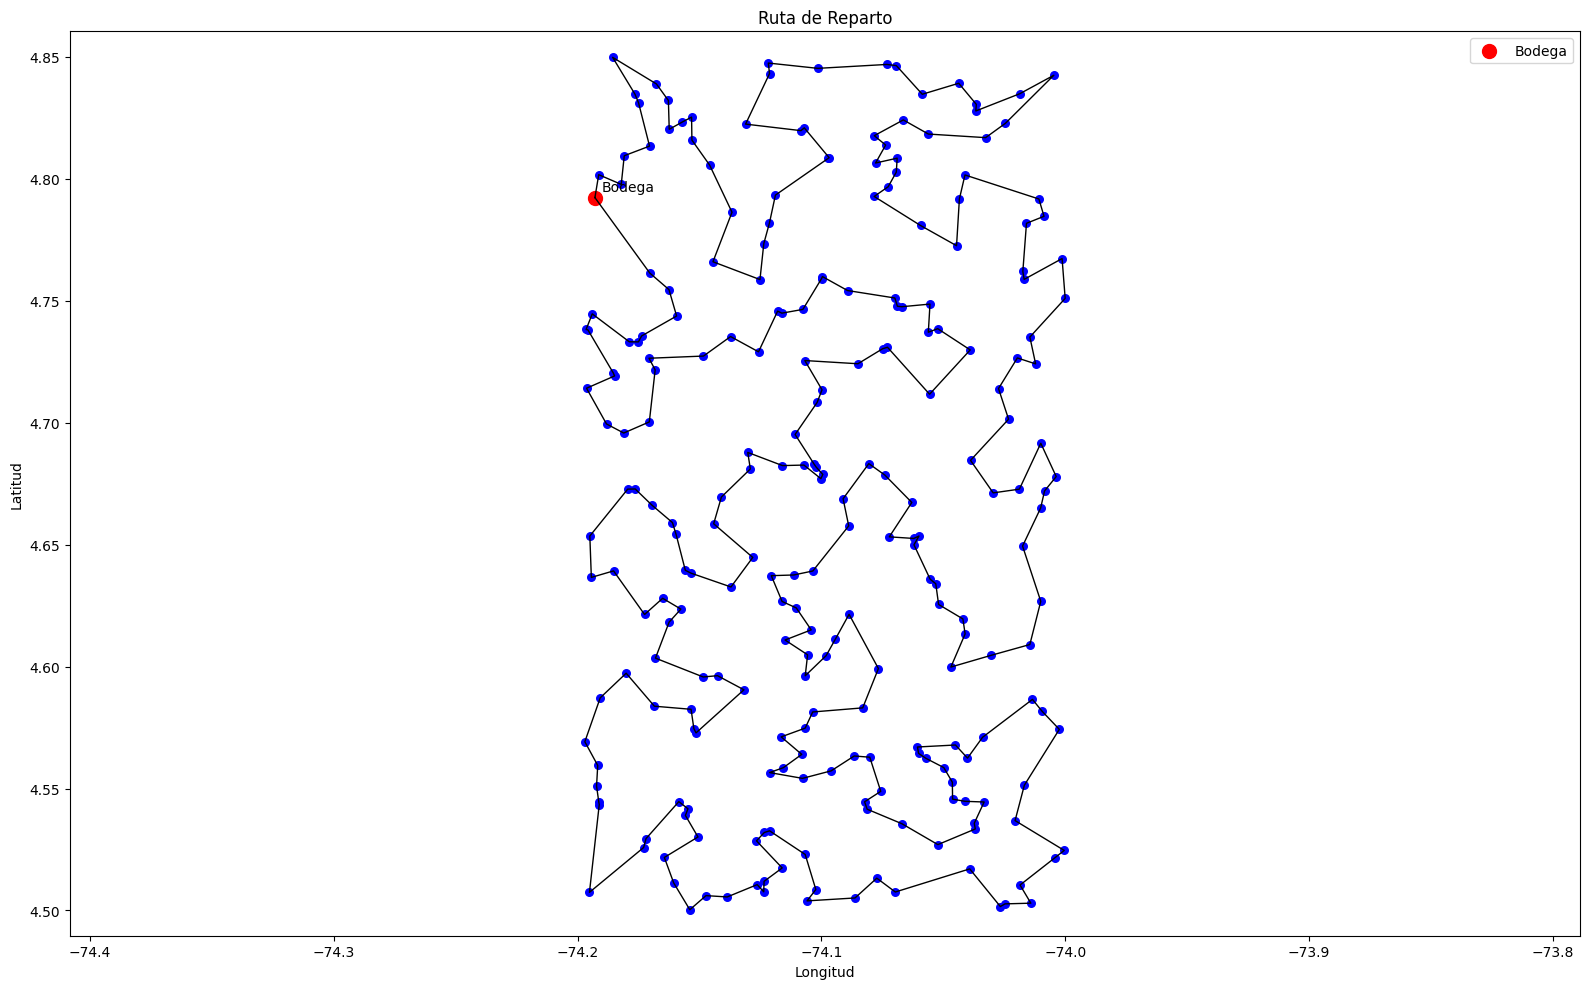

In [58]:
# ============================================================================
# EJECUCIÓN DEL OPTIMIZADOR DE TSP
# ============================================================================
# Este bloque selecciona el método de resolución (exacto o iterativo) según
# el tamaño del espacio de búsqueda. Luego:
#   1. Ejecuta el modelo adecuado
#   2. Recupera y visualiza el tour óptimo
#   3. Registra métricas clave para análisis posterior
# ============================================================================

print("\n -------------------------------- ")
print(" -----    OPTIMIZADOR     ------- ")
print(" -------------------------------- \n")

# --------------------------------------------------------------------------
# 1. ESTIMACIÓN DEL ESPACIO DE BÚSQUEDA
# --------------------------------------------------------------------------
total = contar_subconjuntos(N)
print(f"El espacio de búsqueda es mayor a: {total:.3e} subconjuntos.")

años = estimar_tiempo_exploracion(total)
print(f"Tiempo estimado por fuerza bruta: {años:.3e} años.\n")

# --------------------------------------------------------------------------
# 2. SELECCIÓN DEL MODELO SEGÚN ESCALA DEL PROBLEMA
# --------------------------------------------------------------------------
if años < 1:
    print("Instancia pequeña detectada: se usará modelo clásico.\n")
    t0 = time.perf_counter()
    model, x = optimizar_tcl_clasico(N, A)
    elapsed = time.perf_counter() - t0
else:
    print("Instancia grande detectada: se usará enfoque iterativo (lazy).\n")
    t0 = time.perf_counter()
    model, x = optimizar_tcl_lazy(N, A)
    elapsed = time.perf_counter() - t0

# --------------------------------------------------------------------------
# 3. REPORTE DE RESULTADOS
# --------------------------------------------------------------------------
print("Distancia mínima total:", round(lp.value(model.objective), 2))
print(f"Tiempo de ejecución: {elapsed:.6f} segundos\n")

# --------------------------------------------------------------------------
# 4. RECONSTRUCCIÓN Y VISUALIZACIÓN DEL TOUR
# --------------------------------------------------------------------------
# ▸ Se extraen los arcos activos (x[i,j] = 1) para reconstruir la ruta
sel_arcos = [(i, j) for (i, j) in x if lp.value(x[(i, j)]) == 1]
tour = reconstruir_tour(sel_arcos, N)

# ▸ Visualización gráfica del recorrido en coordenadas reales
graficar_ruta(clientes, tour)

# --------------------------------------------------------------------------
# 5. REGISTRO DE RESULTADOS PARA ANÁLISIS POSTERIOR
# --------------------------------------------------------------------------
resultados.append({
    "Método"    : "LP",
    "Distancia" : round(lp.value(model.objective), 2),
    "Tiempo (s)": round(elapsed, 4)
})


## Heuristicas

### Func. Aux

In [59]:
# ============================================================================
# Cálculo del costo total de un tour dado (TSP)
# ============================================================================
# Recorre la lista ordenada de nodos en el tour y suma el costo de cada arco.
# Asume que el diccionario A contiene los costos entre pares (i, j).
# ============================================================================

def tour_cost(tour: list, A: dict) -> float:
    """
    ============================================================================
    Calcula el costo total asociado a un tour específico
    ─────────────────────────────────────────────────────────────────────────────
    Parámetros:
      • tour : list
          Lista ordenada de nodos visitados, que representa un ciclo (TSP)
      • A    : dict
          Diccionario con distancias o costos: A[(i, j)] = costo entre nodos

    Salida:
      • total : float
          Suma total del recorrido, incluyendo el regreso al nodo inicial

    Notas:
      • Si el tour está cerrado (inicio = fin), el ciclo se considera completo.
      • Si no lo está, esta función lo cierra automáticamente.
    ============================================================================
    """
    total = 0.0
    for k in range(len(tour)):
        i = tour[k]
        j = tour[(k + 1) % len(tour)]  # garantiza el cierre del ciclo
        if i != j:
            total += A[(i, j)]
    return total


In [60]:
# ============================================================================
# Identificación del nodo de inicio (depósito)
# ============================================================================
# Se establece el nodo de partida del tour. Por convención, si el nodo
# "Bodega" existe, se usa como depósito. En su defecto, se usa el primer nodo.
# ============================================================================

depot = "Bodega" if "Bodega" in N else N[0]


### Nearest Neighbor

In [61]:
# ============================================================================
# Heurística Nearest Neighbor (ATSP)
# ============================================================================
# Construye un tour inicial partiendo desde un nodo dado, eligiendo en cada paso
# el nodo no visitado más cercano. Admite grafos dirigidos y asimétricos (A ≠ Aᵗ).
# ============================================================================

def tsp_nn(N: list, A: dict, start: str) -> list:
    """
    ============================================================================
    Heurística de vecino más cercano para TSP (asimétrico)
    ─────────────────────────────────────────────────────────────────────────────
    Parámetros:
      • N     : list
          Lista de nodos (IDs únicos)
      • A     : dict
          Diccionario de costos/distancias: A[(i,j)] = costo de ir de i a j
      • start : str
          Nodo inicial del recorrido (por ejemplo, "Bodega")

    Salida:
      • tour : list
          Lista ordenada de nodos visitados en el tour (sin cerrar)

    Notas:
      • El tour no se cierra automáticamente con el nodo inicial.
        Para cerrar el ciclo, puedes usar: tour + [tour[0]]
    ============================================================================
    """
    unvisited = set(N)
    unvisited.remove(start)

    tour = [start]
    current = start

    while unvisited:
        # Seleccionar el nodo no visitado más cercano desde el actual
        nxt = min(unvisited, key=lambda j: A[(current, j)])
        tour.append(nxt)
        unvisited.remove(nxt)
        current = nxt

    return tour


Distancia total (NN): 437.73
Tiempo de ejecución: 0.007442 segundos


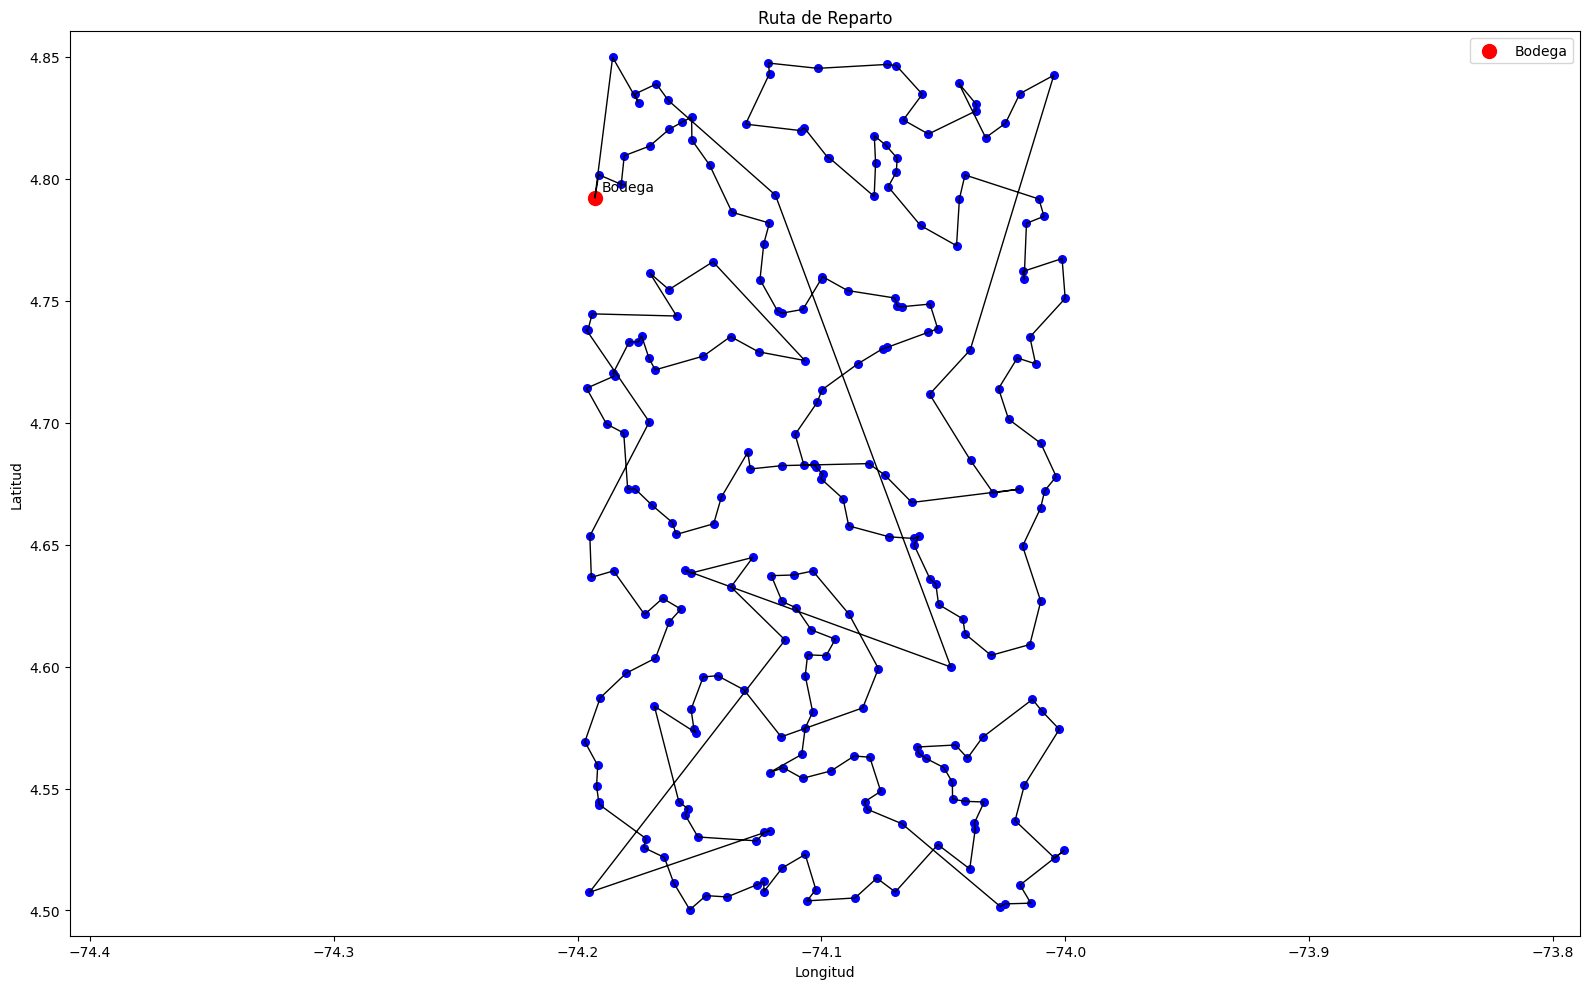

In [62]:
# ============================================================================
# EJECUCIÓN DE HEURÍSTICA NEAREST NEIGHBOR (NN)
# ============================================================================
# Se ejecuta el algoritmo de vecino más cercano partiendo desde el nodo depósito.
# Luego se calcula el costo del tour resultante, se visualiza la ruta y
# se almacenan los resultados para comparación posterior.
# ============================================================================

# --------------------------------------------------------------------------
# 1. EJECUCIÓN DEL ALGORITMO
# --------------------------------------------------------------------------
t0 = time.perf_counter()
tour_nn = tsp_nn(N, A, start=depot)
elapsed = time.perf_counter() - t0

# --------------------------------------------------------------------------
# 2. REPORTE EN CONSOLA
# --------------------------------------------------------------------------
print("Distancia total (NN):", round(tour_cost(tour_nn, A), 2))
print(f"Tiempo de ejecución: {elapsed:.6f} segundos")

# --------------------------------------------------------------------------
# 3. VISUALIZACIÓN DE LA RUTA CONSTRUIDA
# --------------------------------------------------------------------------
graficar_ruta(clientes, tour_nn)

# --------------------------------------------------------------------------
# 4. REGISTRO DE RESULTADOS PARA COMPARACIÓN
# --------------------------------------------------------------------------
resultados.append({
    "Método"    : "NN",
    "Distancia" : round(tour_cost(tour_nn, A), 2),
    "Tiempo (s)": round(elapsed, 4)
})


### Cheapest Insertion 

In [63]:
# ============================================================================
# Heurística Cheapest Insertion (ATSP)
# ============================================================================
# Construye un tour de manera incremental. Parte desde un ciclo de 2 nodos
# y luego inserta el nodo no visitado que cause el menor incremento en el costo.
# Funciona sobre grafos dirigidos (A ≠ Aᵗ) y no requiere matriz simétrica.
# ============================================================================

def tsp_cheapest_insertion(N: list, A: dict, start: str) -> list:
    """
    ============================================================================
    Heurística de inserción más barata para TSP (asimétrico)
    ─────────────────────────────────────────────────────────────────────────────
    Parámetros:
      • N     : list
          Lista de nodos (identificadores únicos)
      • A     : dict
          Diccionario de distancias/costos: A[(i,j)] = costo desde i hasta j
      • start : str
          Nodo desde el cual se inicia el tour

    Salida:
      • tour : list
          Lista ordenada de nodos que forman un ciclo (sin cerrar explícitamente)

    Notas:
      • El tour se forma de manera incremental (nodo por nodo).
      • Usa criterio dirigido: A[i,j] y A[j,i] pueden diferir.
      • El ciclo no se cierra con el nodo inicial; puedes usar tour + [tour[0]]
    ============================================================================
    """

    # ------------------------------------------------------------------------
    # 1. Inicialización: ciclo base con nodo más barato desde el origen
    # ------------------------------------------------------------------------
    otros = [i for i in N if i != start]

    # ▸ Seleccionar nodo inicial k con menor costo de entrada desde start
    k = min(otros, key=lambda j: A[(start, j)])
    tour = [start, k]

    # Lista de nodos aún no insertados
    uninserted = [i for i in otros if i != k]

    # ------------------------------------------------------------------------
    # 2. Insertar nodos uno por uno donde causen menor incremento de costo
    # ------------------------------------------------------------------------
    while uninserted:
        best_delta = float("inf")
        best_pos = None
        best_node = None

        # Evaluar el impacto de insertar cada nodo no insertado en cada hueco del tour
        for node in uninserted:
            for idx in range(len(tour)):
                i = tour[idx]
                j = tour[0] if idx == len(tour) - 1 else tour[idx + 1]

                delta = A[(i, node)] + A[(node, j)] - A[(i, j)]

                if delta < best_delta:
                    best_delta = delta
                    best_pos = idx + 1
                    best_node = node

        # Insertar el mejor nodo en la mejor posición
        tour.insert(best_pos, best_node)
        uninserted.remove(best_node)

    return tour


Distancia total (CI): 411.27
Tiempo de ejecución: 0.395230 segundos


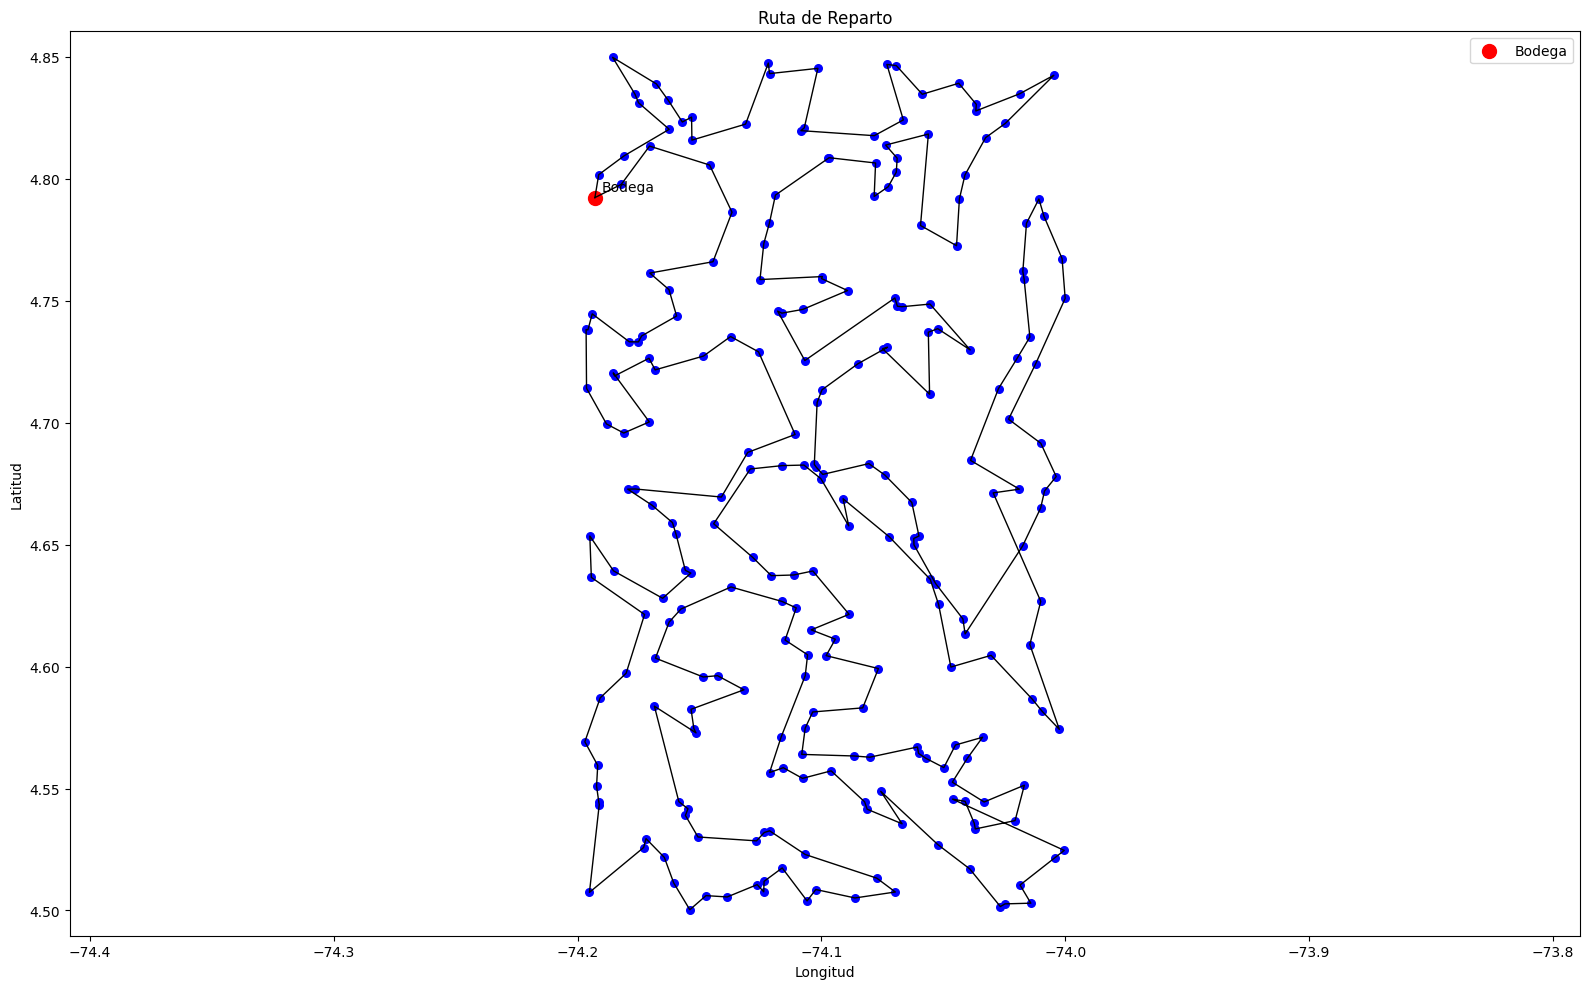

In [64]:
# ============================================================================
# EJECUCIÓN DE HEURÍSTICA CHEAPEST INSERTION (CI)
# ============================================================================
# Ejecuta la heurística de inserción más barata para construir un tour TSP.
# Parte desde el nodo depósito y va insertando el nodo que menos incremente
# el costo total del tour. Se mide el tiempo, calcula el costo y se visualiza.
# ============================================================================

# --------------------------------------------------------------------------
# 1. EJECUCIÓN DEL ALGORITMO
# --------------------------------------------------------------------------
t0 = time.perf_counter()
tour_ci = tsp_cheapest_insertion(N, A, start=depot)
elapsed = time.perf_counter() - t0

# --------------------------------------------------------------------------
# 2. REPORTE EN CONSOLA
# --------------------------------------------------------------------------
print("Distancia total (CI):", round(tour_cost(tour_ci, A), 2))
print(f"Tiempo de ejecución: {elapsed:.6f} segundos")

# --------------------------------------------------------------------------
# 3. VISUALIZACIÓN DE LA RUTA CONSTRUIDA
# --------------------------------------------------------------------------
graficar_ruta(clientes, tour_ci)

# --------------------------------------------------------------------------
# 4. REGISTRO DE RESULTADOS PARA COMPARACIÓN
# --------------------------------------------------------------------------
resultados.append({
    "Método"    : "CI",
    "Distancia" : round(tour_cost(tour_ci, A), 2),
    "Tiempo (s)": round(elapsed, 4)
})


### 2-opt mejora local

In [65]:
# ============================================================================
# Mejora local 2-opt para TSP dirigido (ATSP)
# ============================================================================
# Esta versión de 2-opt está adaptada para instancias dirigidas. A diferencia
# del TSP simétrico, aquí la inversión de un segmento implica reencadenar
# arcos respetando la dirección (A[i,j] ≠ A[j,i]).
# Se evalúan reemplazos de la forma:
#   Romper:    (i → a)  y  (b → j)
#   Reemplazar con: (i → b)  y  (a → j)
# Esto equivale a revertir el subcamino [a..b] manteniendo sentido.
# ============================================================================

import random

def tsp_2opt_atsp(tour: list, A: dict) -> tuple[list, float]:
    """
    ============================================================================
    Mejora local tipo 2-opt para TSP dirigido (ATSP)
    ─────────────────────────────────────────────────────────────────────────────
    Parámetros:
      • tour : list
          Tour inicial (lista ordenada de nodos, sin cerrar explícitamente)
      • A    : dict
          Diccionario de distancias/costos dirigidos: A[(i,j)] = costo i→j

    Salida:
      • best        : list
          Tour mejorado localmente
      • best_cost   : float
          Costo total del tour mejorado

    Notas:
      • La función respeta la dirección de los arcos (ATSP).
      • Si al evaluar un candidato no existe algún arco en A, lo ignora.
      • Finaliza cuando no hay más mejoras posibles.
    ============================================================================
    """
    best = tour[:]
    best_cost = tour_cost(best, A)
    improved = True

    while improved:
        improved = False
        n = len(best)

        # Probar todos los pares (i, k) donde 0 ≤ i < k < n
        for i in range(n - 1):
            for k in range(i + 1, n):
                # Generar candidato invirtiendo el segmento entre i+1 y k
                candidate = (
                    best[:i + 1] +
                    best[i + 1:k + 1][::-1] +
                    best[k + 1:]
                )

                # Evaluar si el tour candidato es válido (tiene todos los arcos)
                try:
                    cand_cost = tour_cost(candidate, A)
                except KeyError:
                    continue  # saltar si algún arco no está definido

                # Aceptar mejora
                if cand_cost < best_cost:
                    best = candidate
                    best_cost = cand_cost
                    improved = True
                    break

            if improved:
                break

    return best, best_cost


Distancia total (NN + 2-opt): 372.28
Tiempo de ejecución: 29.480777 segundos


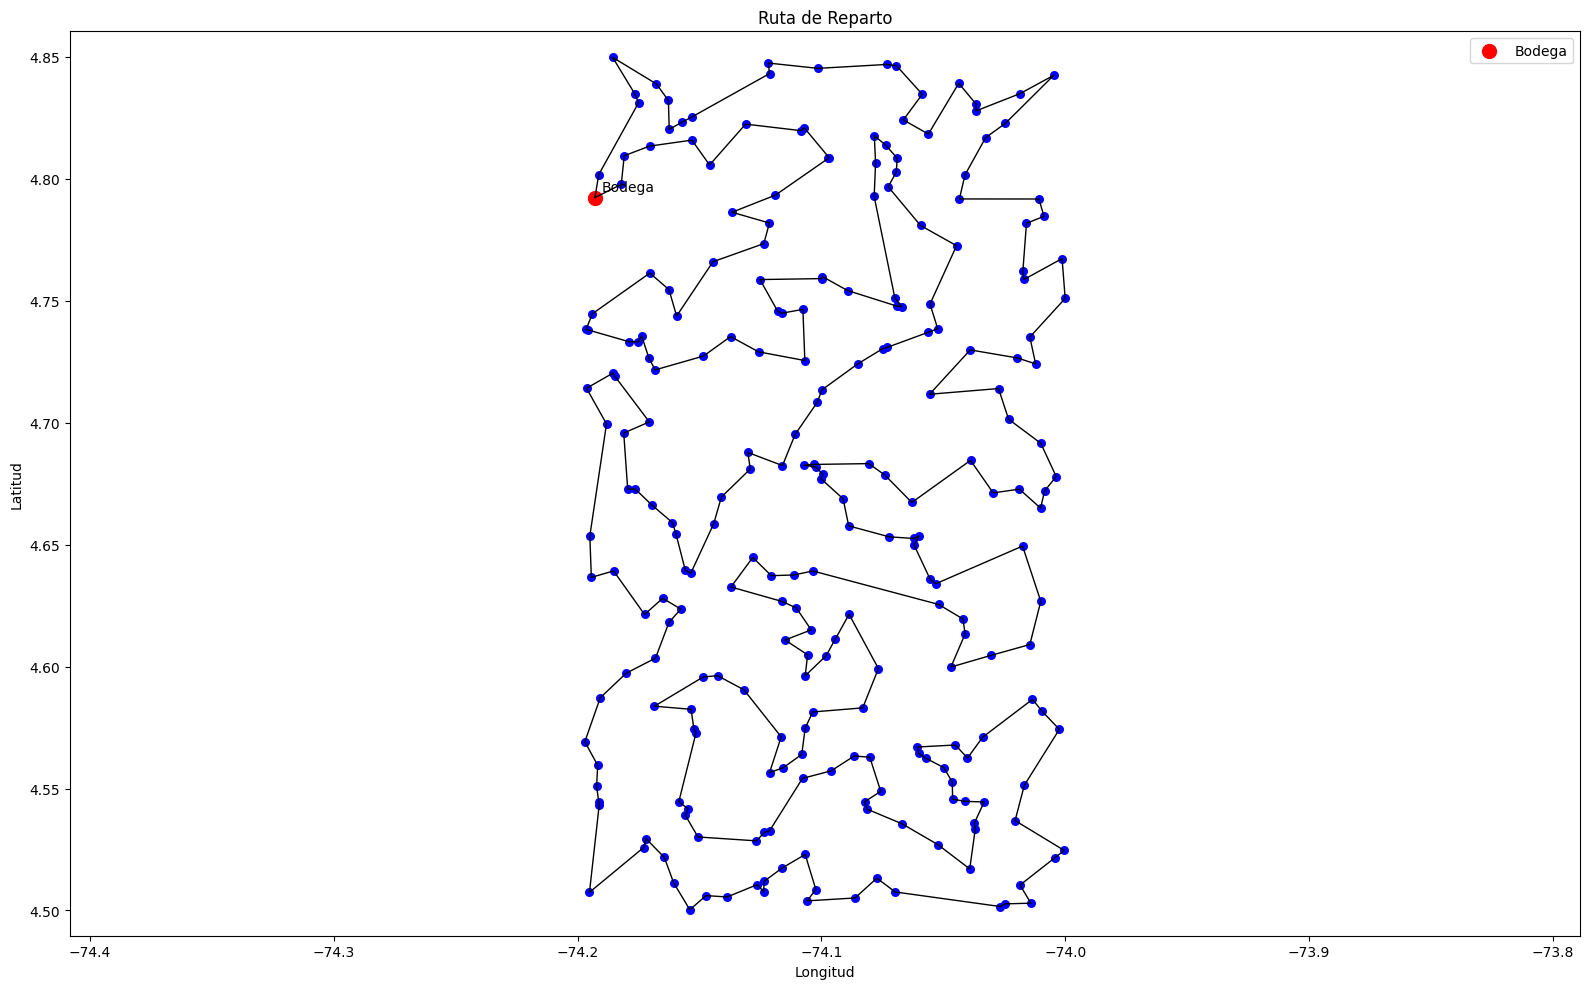

In [66]:
# ============================================================================
# MEJORA LOCAL DEL TOUR NN USANDO 2-OPT DIRIGIDO
# ============================================================================
# Se aplica la heurística de mejora local 2-opt sobre el tour generado por
# el método Nearest Neighbor (NN). La variante utilizada respeta los costos
# dirigidos, lo que la hace adecuada para ATSP. Se mide el tiempo de ejecución,
# se reporta el nuevo costo y se visualiza el recorrido mejorado.
# ============================================================================

# --------------------------------------------------------------------------
# 1. EJECUCIÓN DEL ALGORITMO 2-OPT DIRIGIDO
# --------------------------------------------------------------------------
t0 = time.perf_counter()
tour_nn_opt, cost_nn_opt = tsp_2opt_atsp(tour_nn, A)
elapsed = time.perf_counter() - t0

# --------------------------------------------------------------------------
# 2. REPORTE EN CONSOLA
# --------------------------------------------------------------------------
print("Distancia total (NN + 2-opt):", round(cost_nn_opt, 2))
print(f"Tiempo de ejecución: {elapsed:.6f} segundos")

# --------------------------------------------------------------------------
# 3. VISUALIZACIÓN DE LA RUTA MEJORADA
# --------------------------------------------------------------------------
graficar_ruta(clientes, tour_nn_opt)

# --------------------------------------------------------------------------
# 4. REGISTRO DE RESULTADOS PARA COMPARACIÓN
# --------------------------------------------------------------------------
resultados.append({
    "Método"    : "NN + 2-opt",
    "Distancia" : round(cost_nn_opt, 2),
    "Tiempo (s)": round(elapsed, 4)
})


Distancia total (CI + 2-opt): 378.59
Tiempo de ejecución: 14.602659 segundos


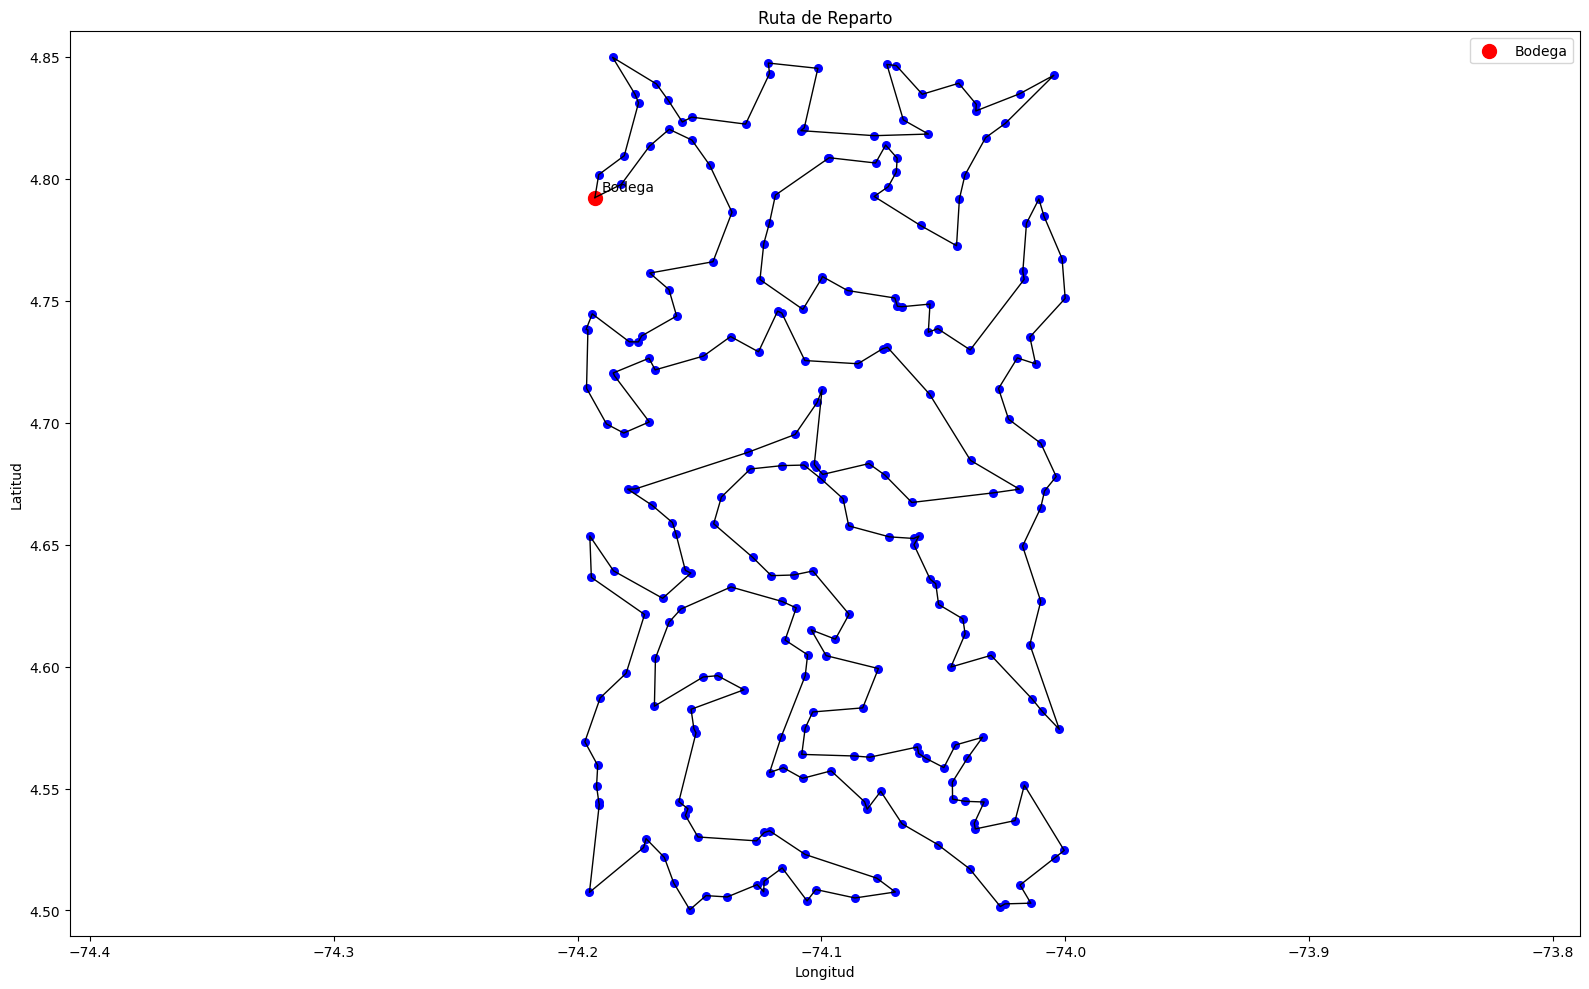

In [67]:
# ============================================================================
# MEJORA LOCAL DEL TOUR CI USANDO 2-OPT DIRIGIDO
# ============================================================================
# Se aplica la heurística de mejora local 2-opt sobre el tour generado por
# Cheapest Insertion (CI), respetando la naturaleza dirigida del grafo (ATSP).
# Se evalúa la calidad de la mejora y se registra para comparación posterior.
# ============================================================================

# --------------------------------------------------------------------------
# 1. EJECUCIÓN DEL ALGORITMO 2-OPT DIRIGIDO
# --------------------------------------------------------------------------
t0 = time.perf_counter()
tour_ci_opt, cost_ci_opt = tsp_2opt_atsp(tour_ci, A)
elapsed = time.perf_counter() - t0

# --------------------------------------------------------------------------
# 2. REPORTE EN CONSOLA
# --------------------------------------------------------------------------
print("Distancia total (CI + 2-opt):", round(cost_ci_opt, 2))
print(f"Tiempo de ejecución: {elapsed:.6f} segundos")

# --------------------------------------------------------------------------
# 3. VISUALIZACIÓN DE LA RUTA MEJORADA
# --------------------------------------------------------------------------
graficar_ruta(clientes, tour_ci_opt)

# --------------------------------------------------------------------------
# 4. REGISTRO DE RESULTADOS PARA COMPARACIÓN
# --------------------------------------------------------------------------
resultados.append({
    "Método"    : "CI + 2-opt",
    "Distancia" : round(cost_ci_opt, 2),
    "Tiempo (s)": round(elapsed, 4)
})


## Resultados

In [68]:
import pandas as pd

# -- Crear DataFrame desde la lista de resultados --
df_resultados = pd.DataFrame(resultados)

# -- Establecer 'Método' como índice --
df_resultados.set_index("Método", inplace=True)

# -- Ordenar por empleos generados (de mayor a menor) --
df_resultados.sort_values("Distancia", ascending=True, inplace=True)

# -- Visualizar resultados ordenados --
df_resultados

,Distancia,Tiempo (s)
Método,,
LP,346.08,167.4127
NN + 2-opt,372.28,29.4808
CI + 2-opt,378.59,14.6027
CI,411.27,0.3952
NN,437.73,0.0074


In [69]:
# -- Tomar la solución base de referencia (LP) --
base_lp = df_resultados.loc["LP"]

# -- Calcular el GAP porcentual relativo al método LP (excepto para Tiempo) --
gap_df = ((df_resultados - base_lp) / base_lp) * 100

# -- Reemplazar la columna de tiempo con "x veces LP" en lugar de porcentaje --
tiempo_ratio = (df_resultados["Tiempo (s)"] / base_lp["Tiempo (s)"]).round(4)

# -- Redondear GAPs a 3 decimales --
gap_df = gap_df.round(3)

# -- Renombrar columnas GAP --
gap_df.columns = [col + " GAP (%)" for col in gap_df.columns]

# -- Reemplazar columna de tiempo con "x veces LP" --
gap_df["Tiempo (s) (x veces LP)"] = tiempo_ratio

# -- Eliminar columna anterior de GAP de tiempo --
gap_df = gap_df.drop(columns=["Tiempo (s) GAP (%)"])

# -- Mostrar tabla --
gap_df

,Distancia GAP (%),Tiempo (s) (x veces LP)
Método,,
LP,0.000,1.0000
NN + 2-opt,7.571,0.1761
CI + 2-opt,9.394,0.0872
CI,18.837,0.0024
NN,26.482,0.0000
